In [1]:
import torch
import numpy as np
import pandas as pd
import DNN_utils as utils
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from datetime import datetime
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import gc
from importlib import reload

In [2]:
# IF EXECUTING ON COLLAB UNCOMMENT THIS CELL

#import os
#from google.colab import drive
#drive.mount('/content/gdrive')
#folder = '/content/gdrive/My Drive/Data ML Project'
#os.chdir(folder)
#print(torch.cuda.is_available())

# Set these right after importing torch, before any other operations
torch.set_num_threads(os.cpu_count())
torch.set_num_interop_threads(os.cpu_count())
path = 'Targets/daily_crsp_sanitized.csv'

In [3]:
daily = utils.read_daily_returns(path, nrows=10000000, low_quantile=0.005, up_quantile=0.995)
daily

Number of daily return outliers: 96,028


,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,sprtrn_lag1
0,2000-01-31,5,15580,6320,0,-0.068182,0.025218,0.000000
1,2000-01-31,7,14593,3573,0,0.020910,0.025218,0.000000
2,2000-01-31,25,62770,6711,0,0.041045,0.025218,0.000000
3,2000-01-31,29,59184,2082,0,0.011236,0.025218,0.000000
4,2000-01-31,33,59248,2082,0,0.034667,0.025218,0.000000
...,...,...,...,...,...,...,...,...
9841513,2005-06-16,20809,23915,2621,322121,0.005097,0.003630,0.002218
9841514,2005-06-16,20812,47888,7373,541512,-0.023644,0.003630,0.002218
9841515,2005-06-16,20813,69999,6726,525990,-0.002842,0.003630,0.002218
9841516,2005-06-16,20818,16424,3421,332211,-0.000768,0.003630,0.002218


In [4]:
# Get data frame of unique months
daily['year_month'] = daily['date'].dt.to_period('M')
unique_months = daily['year_month'].drop_duplicates().sort_values()
unique_months

0          2000-01
8329       2000-02
174757     2000-03
365885     2000-04
523862     2000-05
            ...   
9205863    2005-02
9333674    2005-03
9481683    2005-04
9622885    2005-05
9764141    2005-06
Name: year_month, Length: 66, dtype: period[M]

In [ ]:
# Keeping track of the return over all the data
reload(utils)
all_strategy_returns = []

for i in range(0, len(unique_months) - 6):

    # Train on 6 months of data and test on 1 month
    train_start = unique_months.iloc[i]
    train_end = unique_months.iloc[i+5]
    test_month = unique_months.iloc[i+6]

    print(f'Training from {train_start} to {train_end}. Testing on {test_month}.')
    
    # Filter data
    train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
    test_mask = daily['year_month'] == test_month

    tr_df = daily[train_mask].copy()
    te_df = daily[test_mask].copy()

    # Prepare the data: construct lagged returns, rolling window averages
    train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)
   
    epochs = 5
    max_weight = 0.05  # No stock >5% weight
    diversification_lambda = 0.01  # Strength of penalty
    temperature = 1.0  # Softmax temperature (lower = more diversification)
    train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions, weights = utils.train_DNN(train_df, test_df, features, cat_features, 
                                                                                                   epochs=epochs, max_weight=max_weight, 
                                                                                                   diversification_lambda=diversification_lambda, 
                                                                                                   temperature=temperature)
    # Deduct transaction costs 
    TC_RATE = 0.003 # 0.30% of traded notional value
    alpha = 100

    test_df['weight'] = weights.values
    test_df['weight_change'] = np.abs(test_df['weight'].diff().fillna(0.0))
    test_df['tc_cost'] = test_df['weight_change'].apply(lambda x: utils.progressive_cost(x, base_tc=TC_RATE, alpha=alpha))
    test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet'] - test_df['tc_cost']
    mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()

    all_strategy_returns.append(mean_daily_returns)
    gc.collect() # Memory clean-up

# Concatenate all windows into one Series
combined_returns = pd.concat(all_strategy_returns)



Training from 2000-01 to 2000-06. Testing on 2000-07.
['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 435 train batches, 41 test batches


Training:  20%|███████                            | 1/5 [00:16<01:06, 16.53s/it]

Epoch 1/5, Loss: -0.0745, Train fit: 0.0116, Test fit: 0.0029, Avg Weight: 0.0002, Max Weight: 0.0010


Training:  60%|█████████████████████              | 3/5 [00:46<00:30, 15.23s/it]

Epoch 3/5, Loss: -0.0890, Train fit: 0.0355, Test fit: 0.0258, Avg Weight: 0.0002, Max Weight: 0.0010


Training: 100%|███████████████████████████████████| 5/5 [01:16<00:00, 15.36s/it]

Epoch 5/5, Loss: -0.1102, Train fit: 0.0511, Test fit: 0.0474, Avg Weight: 0.0002, Max Weight: 0.0013
Training completed! Best test Sharpe ratio: 0.0474
Training from 2000-02 to 2000-07. Testing on 2000-08.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 512 train batches, 47 test batches


Training:  20%|███████                            | 1/5 [00:17<01:11, 17.97s/it]

Epoch 1/5, Loss: -0.0705, Train fit: 0.0087, Test fit: 0.0519, Avg Weight: 0.0002, Max Weight: 0.0007


Training:  60%|█████████████████████              | 3/5 [00:54<00:36, 18.32s/it]

Epoch 3/5, Loss: -0.0901, Train fit: 0.0419, Test fit: 0.0769, Avg Weight: 0.0002, Max Weight: 0.0013


Training: 100%|███████████████████████████████████| 5/5 [01:30<00:00, 18.13s/it]

Epoch 5/5, Loss: -0.1117, Train fit: 0.0569, Test fit: 0.0739, Avg Weight: 0.0002, Max Weight: 0.0017
Training completed! Best test Sharpe ratio: 0.0770
Training from 2000-03 to 2000-08. Testing on 2000-09.


['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 525 train batches, 41 test batches


Training:  20%|███████                            | 1/5 [00:21<01:27, 21.84s/it]

Epoch 1/5, Loss: -0.0749, Train fit: 0.0061, Test fit: -0.0272, Avg Weight: 0.0002, Max Weight: 0.0008


Training:  60%|█████████████████████              | 3/5 [00:58<00:37, 18.95s/it]

In [ ]:
# Plot the cumulative returns of the strategy and compare with the S&P 500 index
cumulative_returns = (1 + combined_returns).cumprod() 
sp_ret = daily.groupby('date')['sprtrn'].mean()

strat_start = unique_months.iloc[6].to_timestamp()
sp_ret = sp_ret.loc[strat_start:]

cumulative_sp500 = (1 + sp_ret).cumprod()

# Combine into a single DataFrame for easy plotting
combined = pd.DataFrame({
    'Strategy': cumulative_returns,
    'S&P 500': cumulative_sp500
})

# Sharpe ratio
strat_sharpe = utils.compute_sharpe(combined_returns)
sp_sharpe = utils.compute_sharpe(sp_ret)

# Plot
combined.plot(figsize=(10, 6), title=f'Cumulative Returns: Strategy (Sharpe={strat_sharpe:.2f}) vs S&P 500 (Sharpe={sp_sharpe:.2f}) ')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

# ------------------------------------------------------------------------------------------------------------------

In [22]:
end_date = sp_ret.index.max()
end_date

Timestamp('2005-06-16 00:00:00')

In [27]:
regression = pd.read_csv('base_benchmark_regul.csv', usecols=['date', 'cumulative_1dollar'])
regression['date'] = pd.to_datetime(regression['date'], format="%Y-%m-%d")
regression = regression.loc[regression['date'] <= end_date]
regression = regression.set_index('date')
regression

,cumulative_1dollar
date,
2000-07-03,0.997942
2000-07-05,0.997489
2000-07-06,0.996326
2000-07-07,1.000691
2000-07-10,1.013719
...,...
2005-06-10,2.359190
2005-06-13,2.365178
2005-06-14,2.375978


In [36]:
type(pd.Series(regression['cumulative_1dollar']))

pandas.core.series.Series

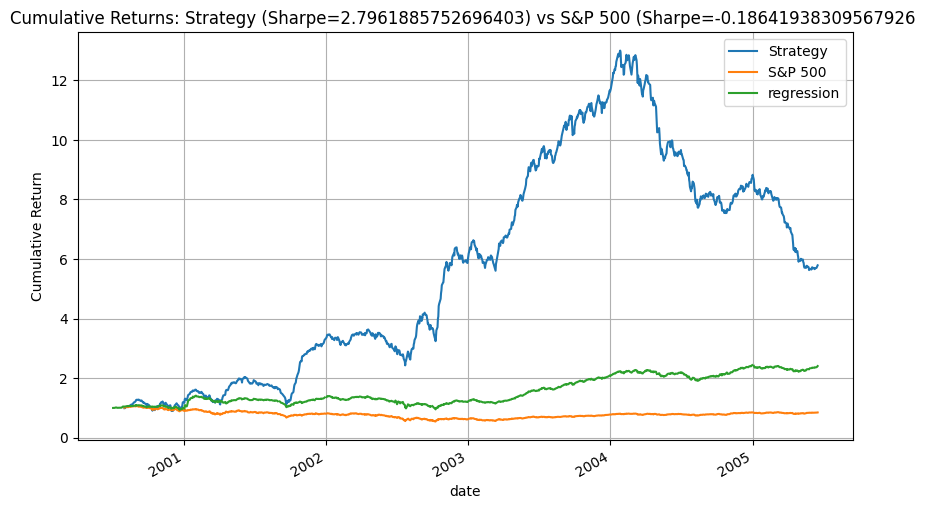

In [38]:
# Combine into a single DataFrame for easy plotting
combined = pd.DataFrame({
    'Strategy': cumulative_returns,
    'S&P 500': cumulative_sp500,
    'regression': pd.Series(regression['cumulative_1dollar'])
})

# Sharpe ratio
strat_sharpe = np.sqrt(combined_returns.shape[0]) * (combined_returns.mean() / combined_returns.std())
sp_sharpe = np.sqrt(sp_ret.shape[0]) * (sp_ret.mean() / sp_ret.std())

# Plot
combined.plot(figsize=(10, 6), title=f'Cumulative Returns: Strategy (Sharpe={strat_sharpe}) vs S&P 500 (Sharpe={sp_sharpe} ')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()



In [41]:
# Keeping track of the return over all the data
reload(utils)
all_strategy_returns = []

for i in range(0, 11 - 6 - 1):

    # Train on 6 months of data and test on 1 month
    train_start = unique_months.iloc[i]
    train_end = unique_months.iloc[i+6]
    test_month = unique_months.iloc[i+7]

    print(f'Training from {train_start} to {train_end}. Testing on {test_month}.')
    
    # Filter data
    train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
    test_mask = daily['year_month'] == test_month

    tr_df = daily[train_mask].copy()
    te_df = daily[test_mask].copy()

    # Prepare the data: construct lagged returns, rolling window averages
    train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)
   
    epochs = 5
    max_weight = 0.05  # No stock >5% weight
    diversification_lambda = 0.01  # Strength of penalty
    temperature = 1.0  # Softmax temperature (lower = more diversification)
    train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions, weights = utils.train_DNN(train_df, test_df, features, cat_features, 
                                                                                                   epochs=epochs, max_weight=max_weight, 
                                                                                                   diversification_lambda=diversification_lambda, 
                                                                                                   temperature=temperature)
    # Deduct transaction costs 
    TC_RATE = 0.003 # 0.20% of traded notional value
    alpha = 100

    test_df['weight'] = weights.values
    test_df['weight_change'] = np.abs(test_df['weight'].diff().fillna(0.0))
    #test_df['tc_cost'] = test_df['weight_change'].apply(utils.progressive_cost) * TC_RATE # Apply increasing costs relative to trade size
    test_df['tc_cost'] = test_df['weight_change'].apply(lambda x: utils.progressive_cost(x, base_tc=TC_RATE, alpha=alpha))
    test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet'] - test_df['tc_cost']
    mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()

    all_strategy_returns.append(mean_daily_returns)
    gc.collect() # Memory clean-up

# Concatenate all windows into one Series
combined_returns = pd.concat(all_strategy_returns)



Training from 2000-01 to 2000-07. Testing on 2000-08.
['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 516 train batches, 47 test batches


Training:  20%|███████                            | 1/5 [00:21<01:25, 21.42s/it]

Epoch 1/5, Loss: -0.0712, Train Sharpe: 0.0113, Test Sharpe: 0.0421, Avg Weight: 0.0002, Max Weight: 0.0011


Training:  60%|█████████████████████              | 3/5 [01:01<00:41, 20.59s/it]

Epoch 3/5, Loss: -0.1039, Train Sharpe: 0.0555, Test Sharpe: 0.0652, Avg Weight: 0.0002, Max Weight: 0.0026


Training: 100%|███████████████████████████████████| 5/5 [01:41<00:00, 20.24s/it]

Epoch 5/5, Loss: -0.1168, Train Sharpe: 0.0623, Test Sharpe: 0.0654, Avg Weight: 0.0002, Max Weight: 0.0049
Training completed! Best test Sharpe ratio: 0.0654


Training from 2000-02 to 2000-08. Testing on 2000-09.
['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 606 train batches, 41 test batches


Training:  20%|███████                            | 1/5 [00:22<01:28, 22.04s/it]

Epoch 1/5, Loss: -0.0803, Train Sharpe: 0.0168, Test Sharpe: -0.0304, Avg Weight: 0.0002, Max Weight: 0.0008


Training:  60%|█████████████████████              | 3/5 [01:10<00:46, 23.44s/it]

Epoch 3/5, Loss: -0.1010, Train Sharpe: 0.0457, Test Sharpe: 0.0085, Avg Weight: 0.0002, Max Weight: 0.0015


Training: 100%|███████████████████████████████████| 5/5 [01:53<00:00, 22.79s/it]

Epoch 5/5, Loss: -0.1198, Train Sharpe: 0.0539, Test Sharpe: 0.0159, Avg Weight: 0.0002, Max Weight: 0.0017
Training completed! Best test Sharpe ratio: 0.0159


Training from 2000-03 to 2000-09. Testing on 2000-10.
['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 606 train batches, 45 test batches


Training:  20%|███████                            | 1/5 [00:21<01:27, 22.00s/it]

Epoch 1/5, Loss: -0.0682, Train Sharpe: 0.0094, Test Sharpe: -0.0219, Avg Weight: 0.0002, Max Weight: 0.0013


Training:  60%|█████████████████████              | 3/5 [01:05<00:43, 21.74s/it]

Epoch 3/5, Loss: -0.1100, Train Sharpe: 0.0552, Test Sharpe: 0.0319, Avg Weight: 0.0002, Max Weight: 0.0029


Training: 100%|███████████████████████████████████| 5/5 [01:51<00:00, 22.26s/it]

Epoch 5/5, Loss: -0.1225, Train Sharpe: 0.0646, Test Sharpe: 0.0368, Avg Weight: 0.0002, Max Weight: 0.0037
Training completed! Best test Sharpe ratio: 0.0378


Training from 2000-04 to 2000-10. Testing on 2000-11.
['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']
Starting training with 602 train batches, 43 test batches


Training:  20%|███████                            | 1/5 [00:23<01:32, 23.13s/it]

Epoch 1/5, Loss: -0.0684, Train Sharpe: 0.0162, Test Sharpe: -0.0626, Avg Weight: 0.0002, Max Weight: 0.0031


Training:  60%|█████████████████████              | 3/5 [01:09<00:46, 23.42s/it]

Epoch 3/5, Loss: -0.1134, Train Sharpe: 0.0620, Test Sharpe: -0.0137, Avg Weight: 0.0002, Max Weight: 0.0038


Training: 100%|███████████████████████████████████| 5/5 [01:57<00:00, 23.58s/it]

Epoch 5/5, Loss: -0.1237, Train Sharpe: 0.0671, Test Sharpe: -0.0064, Avg Weight: 0.0002, Max Weight: 0.0041
Training completed! Best test Sharpe ratio: -0.0064


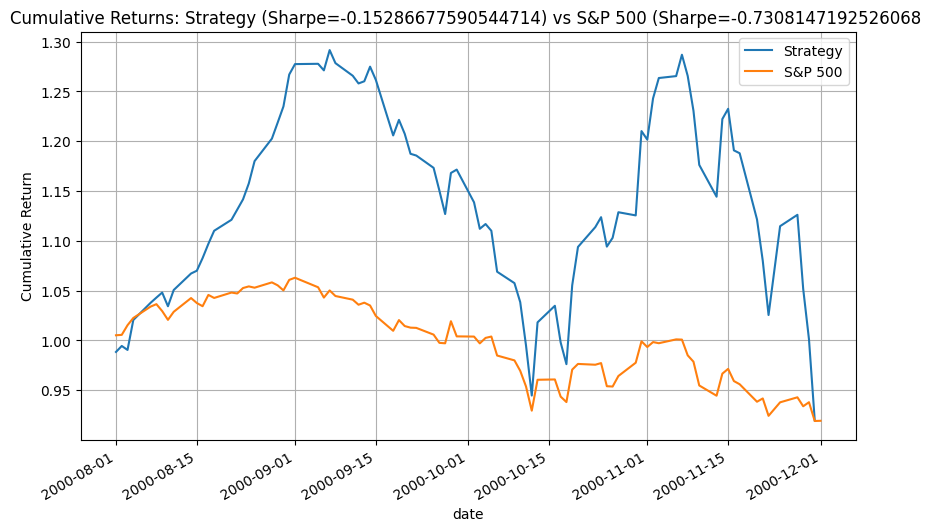

In [43]:
# Plot the cumulative returns of the strategy and compare with the S&P 500 index
cumulative_returns = (1 + combined_returns).cumprod() 
sp_ret = daily.groupby('date')['sprtrn'].mean()

strat_start = unique_months.iloc[7].to_timestamp()
sp_ret = sp_ret.loc[strat_start:'2000-12-01']

cumulative_sp500 = (1 + sp_ret).cumprod()

# Combine into a single DataFrame for easy plotting
combined = pd.DataFrame({
    'Strategy': cumulative_returns,
    'S&P 500': cumulative_sp500
})

# Sharpe ratio
strat_sharpe = np.sqrt(combined_returns.shape[0]) * (combined_returns.mean() / combined_returns.std())
sp_sharpe = np.sqrt(sp_ret.shape[0]) * (sp_ret.mean() / sp_ret.std())

# Plot
combined.plot(figsize=(10, 6), title=f'Cumulative Returns: Strategy (Sharpe={strat_sharpe}) vs S&P 500 (Sharpe={sp_sharpe} ')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()